# Approximating likelihood ratios with calibrated classifiers

Gilles Louppe, January 2016.


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import theano
import theano.tensor as T

In [2]:
from sklearn.utils import check_random_state
from scipy.optimize import minimize
from scipy.stats import chi2, norm

## Toy problem

Let us consider two 1D distributions $p_0$ and $p_1$ for which we want to approximate the ratio $r(x) = \frac{p_0(x)}{p_1(x)}$ of their densities.

- $p_1$ is defined as a mixture of two gaussians;
- $p_0$ is defined as a mixture of the same two gaussians + a bump.

In [4]:
from carl.distributions import Normal
from carl.distributions import Mixture

components = [
    Normal(mu=-2.0, sigma=0.75),   # c0
    Normal(mu=0.0, sigma=2.0),     # c1
    Normal(mu=1.0, sigma=0.5)      # c2 (bump)
]

bump_coefficient = 0.05
g = theano.shared(bump_coefficient) 
p0 = Mixture(components=components, weights=[0.5 - g / 2., 0.5 - g / 2., g])
p1 = Mixture(components=components[:2], weights=[0.5, 0.5])

Note: for $p_0$, weights are all tied together through the Theano shared variable `g`. This means that changes to the value stored in `g` also automatically change the weight values and the resulting mixture.

In [5]:
N_obs_samples=5000
X_true = p0.rvs(N_obs_samples)

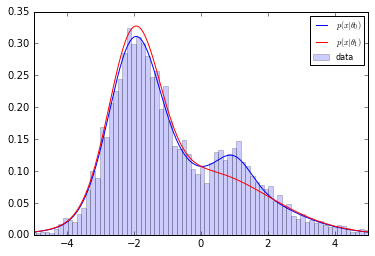

In [6]:
reals = np.linspace(-5, 5, num=1000)
plt.plot(reals, p0.pdf(reals.reshape(-1, 1)), label=r"$p(x|\theta_0)$", color="b")
plt.plot(reals, p1.pdf(reals.reshape(-1, 1)), label=r"$p(x|\theta_1)$", color="r")
plt.hist(X_true[:, 0], bins=100, normed=True, label="data", alpha=0.2, color="b")
plt.xlim(-5, 5)
plt.legend(loc="best", prop={'size': 8})
plt.show()

## Density ratio estimation

The density ratio $r(x)$ can be approximated using calibrated classifiers, either directly by learning to classify $x \sim p_0$ from $x \sim p_1$, or by decomposing the ratio of the two mixtures as pairs of simpler density ratios.

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

from carl.ratios import ClassifierRatio
from carl.ratios import DecomposedRatio
from carl.learning import CalibratedClassifierCV

# Classifier
# from sklearn.linear_model import ElasticNetCV
# clf = ElasticNetCV()

from sklearn.neural_network import MLPRegressor
#clf = MLPRegressor(activation="tanh", hidden_layer_sizes=(10, 10), random_state=0)
clf = MLPRegressor(tol=1e-05, activation="logistic", 
                   hidden_layer_sizes=(10, 10), learning_rate_init=1e-07, 
                   learning_rate="constant", algorithm="l-bfgs", random_state=1, 
                   max_iter=75)

# from sklearn.ensemble import ExtraTreesRegressor
# clf = ExtraTreesRegressor(n_estimators=250, max_leaf_nodes=15)

n_train_samples = 100000
n_calibration_samples = 100000*5

# No calibration
cc_none = ClassifierRatio(base_estimator=clf)
cc_none.fit(numerator=p0, denominator=p1, n_samples=n_train_samples)

# Calibration + Direct approximation 
cv = StratifiedShuffleSplit(n_iter=1, test_size=0.75, random_state=0)  # 25% for training, 75% for calibration
cc_direct = ClassifierRatio(base_estimator=CalibratedClassifierCV(clf, cv=cv))
cc_direct.fit(numerator=p0, denominator=p1, n_samples=n_train_samples)

# Calibration + Decomposition of the mixture
cc_decomposed = DecomposedRatio(ClassifierRatio(base_estimator=CalibratedClassifierCV(clf, cv=cv,bins=30)))
cc_decomposed.fit(numerator=p0, denominator=p1, n_samples=n_calibration_samples)

DecomposedRatio(base_ratio=ClassifierRatio(base_estimator=CalibratedClassifierCV(base_estimator=MLPRegressor(activation='logistic', algorithm='l-bfgs', alpha=0.0001,
       batch_size=200, beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(10, 10),
       learning_rate='constant', learning_rate_init=1e-...ter=1, random_state=0, test_size=0.75,
            train_size=None),
            method='histogram'),
        random_state=None))

Note: `CalibratedClassifierRatio` takes three arguments for controlling its execution:
- `base_estimator` specifying the classifier to be used,
- `calibration` specifying the calibration algorithm (`"kde"`, `"histogram"`, or a user-defined distribution-like object),
- `cv` specifying how to allocate data for training and calibration.

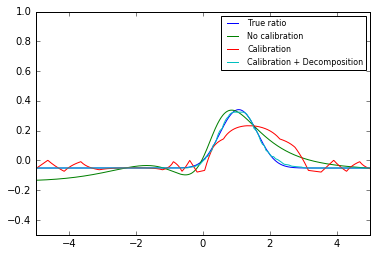

In [48]:
plt.plot(reals, -p0.nnlf(reals.reshape(-1, 1))  
                +p1.nnlf(reals.reshape(-1, 1)), label="True ratio")

plt.plot(reals, cc_none.predict(reals.reshape(-1, 1), log=True), label="No calibration")
plt.plot(reals, cc_direct.predict(reals.reshape(-1, 1), log=True), label="Calibration")
plt.plot(reals, cc_decomposed.predict(reals.reshape(-1, 1), log=True), label="Calibration + Decomposition")

plt.xlim(-5, 5)
plt.ylim(-0.5, 1.)
plt.legend(loc="best", prop={'size': 8})
plt.show()

## Using density ratios for maximum likelihood fit

In the likelihood-free setting, density ratios can be used to find the maximum likelihood estimator $\theta^* = \arg \max_{\theta} p(D | \theta)$ by noticing that $\theta^*$ also maximizes $\prod_{x \in D} \frac{p(x|\theta)}{p(x|\theta_1)}$ for some fixed value of $\theta_1$.

As an example, this can be used to find the bump coefficient in $p_1$, as illustrated below:

## likelihood plot

In [49]:
def vectorize(func):
    def wrapper(X):
        v = np.zeros(len(X))
        
        for i, x_i in enumerate(X):
            v[i] = func(x_i)
            
        return v.reshape(-1, 1)
    
    return wrapper

In [50]:
def nll_true(theta, data=X_true):       
    g.set_value(theta)  # this indirectly updates weights in p1, 
                           # along with the density ratios computed by cc 
                           # (without having to retrain the classifiers since 
                           # g only affects the weights!)

    return (p0.nnlf(data) - p1.nnlf(data)).sum()

def nll_approx(theta, data=X_true):       
    g.set_value(theta)  # this indirectly updates weights in p1, 
                           # along with the density ratios computed by cc 
                           # (without having to retrain the classifiers since 
                           # g only affects the weights!)

    cc = cc_decomposed

    # do we need to refit since p0 changed?
    #cc.fit(numerator=p0, denominator=p1, n_samples=n_calibration_samples)
    
    return -np.sum(cc.predict(data, log=True))

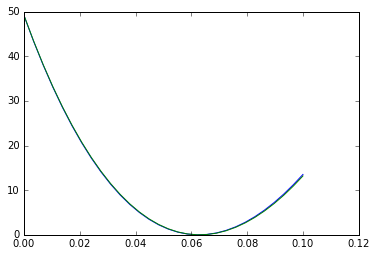

In [51]:
g_scan = np.linspace(0.0, 2*bump_coefficient,30)
nll_true_scan = vectorize(nll_true)(g_scan)
nll_approx_scan = vectorize(nll_approx)(g_scan)

plt.plot(g_scan, nll_true_scan-nll_true_scan.min())
plt.plot(g_scan, nll_approx_scan-nll_approx_scan.min())


## ensemble tests

Noticing some bias, but the bias is also present for the true likelihood

In [52]:
n_trials = 1000
true_mles = []
true_nll = []
approx_mles = []
approx_nll = []

for i in range(n_trials):  
    # Reset
    rng = check_random_state(i)
    #p0.set_params(random_state=rng)
    #p1.set_params(random_state=rng)
    
    g.set_value(bump_coefficient)
    X_toy = p0.rvs(N_obs_samples,random_state=rng)
    


    # do fits for true likelihood
    def true_objective(theta):       
        return nll_true(theta[0], data=X_toy)
    
    # debugging
    def true_objective2(theta):
        g.set_value(theta[0])
        
        return (p0.nnlf(X_toy) - p1.nnlf(X_toy)).sum()


    true_objective=true_objective2
    results = minimize(true_objective, x0=[0.1], 
                       constraints=[{'type':'ineq', 'fun': lambda x: x[0]},
                                    {'type':'ineq', 'fun': lambda x: 1. - x[0]},])

    # add NLL evaluate at true point
    nll_at_mle = results.fun

    true_mles.append(results.x[0])
    g.set_value(bump_coefficient)
    nll_at_true = true_objective([bump_coefficient])
    true_nll.append(2.*(nll_at_true - nll_at_mle))
    
    # do fits for approx likelihood

    # Fit ratio
    cc = cc_decomposed
    # do we need to refit since p0 changed?
    # oh, should probably go into the nll evaluation
    # would be nice if these could be cached... no need to build
    # distributions for p0 and p1 for each toy, they will be the same
    # not important for a single fit, but is for ensemble tests
    #cc.fit(numerator=p0, denominator=p1, n_samples=n_calibration_samples)


    def approx_objective(theta):       
        return nll_approx(theta[0], data=X_toy)
    

    results = minimize(approx_objective, x0=[0.1], 
                       constraints=[{'type':'ineq', 'fun': lambda x: x[0]},
                                    {'type':'ineq', 'fun': lambda x: 1. - x[0]},])

    # add NLL evaluate at true point
    nll_at_mle = results.fun

    g.set_value(bump_coefficient)
    nll_at_true = approx_objective([bump_coefficient])
    approx_nll.append(2.*(nll_at_true - nll_at_mle))
    approx_mles.append(results.x[0])
    '''
    '''


    approx_nll.append(2.*(nll_at_true - nll_at_mle))
    approx_mles.append(results.x[0])
    
    if i%100 ==0 :
        print(i)
        print("nll: ", nll_at_mle, nll_at_true)

0
nll:  -33.4107607169 -33.393815051
100
nll:  -32.5100123008 -32.4983659504
200
nll:  -34.3892442629 -34.3349272838
300
nll:  -35.979313669 -35.8210164552
400
nll:  -22.4989549606 -21.7631108814
500
nll:  -19.8601907851 -18.6572111005
600
nll:  -15.9863007124 -13.5302525267
700
nll:  -32.5449134382 -32.5337010362
800
nll:  -27.9148942366 -27.8186965443
900
nll:  -33.1211489162 -33.1073284679


In [53]:
true_mles=np.array(true_mles)
true_mles=true_mles[np.isfinite(true_mles)]
approx_mles=np.array(approx_mles)
approx_mles=approx_mles[np.isfinite(approx_mles)]
np.mean(true_mles), np.mean(approx_mles),(bump_coefficient-np.mean(true_mles))/(np.std(true_mles)/np.sqrt(true_mles.size)), (bump_coefficient-np.mean(approx_mles))/(np.std(approx_mles)/np.sqrt(approx_mles.size))

(0.050114731288578115,
 0.050055323593943567,
 -0.54286922011463024,
 -0.36837663501625995)

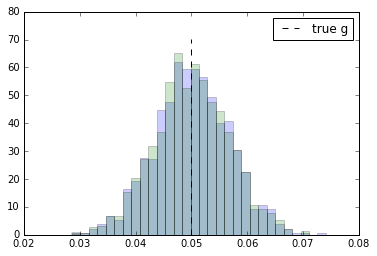

In [54]:
h = plt.hist(true_mles, bins=30, normed=1, alpha=0.2, color='b')
h = plt.hist(approx_mles, bins=h[1], normed=1, alpha=0.2, color='g')
plt.vlines(bump_coefficient, 0, h[0].max()+5, linestyles="dashed", label="true g")
plt.legend()
plt.show()

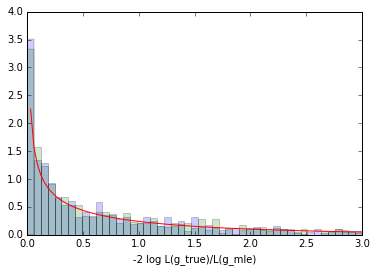

In [55]:
bins = np.linspace(0,3,50)
test = np.linspace(0,3,100)
true_counts, bins, patches = plt.hist(2*true_nll, bins=bins, normed=1, alpha=0.2)
approx_counts, bins, patches = plt.hist(2*approx_nll, bins=bins, normed=1, alpha=0.2)
plt.plot(test, chi2.pdf(test,df=1))
plt.xlabel('-2 log L(g_true)/L(g_mle)')
#plt.ylim(1e-2,5)
#plt.semilogy()

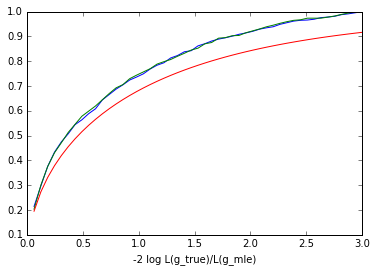

In [56]:
plt.plot(bins[1:], np.cumsum(true_counts)*(bins[1]-bins[0]), c='b')
plt.plot(bins[1:], np.cumsum(approx_counts)*(bins[1]-bins[0]), c='green')
plt.plot(bins[1:], chi2.cdf(bins[1:],df=1), c='red')
plt.xlabel('-2 log L(g_true)/L(g_mle)')

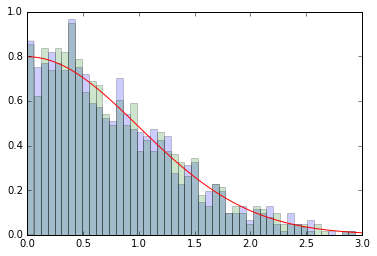

In [57]:
counts, bins, patches = plt.hist(np.sqrt(2*true_nll), bins=bins, normed=1, alpha=0.2, color='b')
counts, bins, patches = plt.hist(np.sqrt(2*approx_nll), bins=bins, normed=1, alpha=0.2, color='g')
plt.plot(test, 2*norm.pdf(test), c='r')